# EX_15 문자를 읽을 수 있는 딥러닝

## 목표: 다양한 OCR모델 비교하기

### lubric

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가? 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가? 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.


### 학습 목표

- OCR의 과정을 이해합니다.
- 문자인식 결과의 표현방식을 이해합니다.
- 파이썬을 통해 OCR을 사용할 수 있습니다.

### 🚩keyword

✔ Text Detection(문자검출), Text Recognition(문자인식), Object Detection(객체 인식), Google OCR API, keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR, 검출 모델로는 CRAFT(Character Region Awareness for Text Detection)를 사용, 인식 모델로는 앞에서 설명한 CRNN을 사용, 테서랙트(Tesseract)(Pytesseract)

### 내가 기획한 서비스: 와인 라벨을 글로 알려주는 서비스

- 와인 라벨을 보면 보통 이름이 제일 크게 써있고 그 아래에 세부 설명이 작은 글씨로 써있다. 와인라벨은 모든 부분이 중요한 정보라서 그 작은 글씨도 읽을 수 있게 글로 알려준다면 좋을 것 같다. 
- 사실 이 서비스는 이미 vivino라는 애플리케이션에서 쓰고 있다. 라벨 사진을 찍으면 문자를 인식해서 그 와인을 찾아주는 서비스로 그렇게 찾은 와인에 리뷰를 남길 수 있다. 하지만 와인 하나만을 찍어야하고 각도가 정면과 살짝 틀어지거나 라벨링의 손상도가 있을 때 급격하게 인식률이 떨어져서 가끔 화가날 때가 있었는데 이번 기회에 이 OCR 서비스를 조금 더 이해하는 방향으로 공부를 해보려한다
- 성능에 영향을 미치는 요인으론 텍스트의 모양과 크기, 노이즈, 와인의 갯수, 각도를 기준으로 하겠다.
- 라벨에 있는 텍스트의 모양과 크기에 관계없이 모든 글자를 인식할 수 있는지, 다수의 와인이 있을 때 모든 라벨을 인식할 수 있는지, 각도가 정면이 아님에도 정확한 인식이 가능한지를 중점으로 판단해보려 한다.

### Step1. 검증용 데이터셋 준비

- OCR의 성능에 영향을 미치는 요인: 텍스트의 모양과 크기, 배치, 노이즈
- 총 20장을 넘지 않도록 준비

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
data_path = os.getenv('HOME')+ '/aiffel/EXPLORATIONS/EX_15/wine_img/'

In [3]:
images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180156953.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180155805.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180206123.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180201562.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180207558.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180159784.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180211060.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180158375.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180214405.jpg',
 '/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/KakaoTalk_20220303_180154584.jpg']

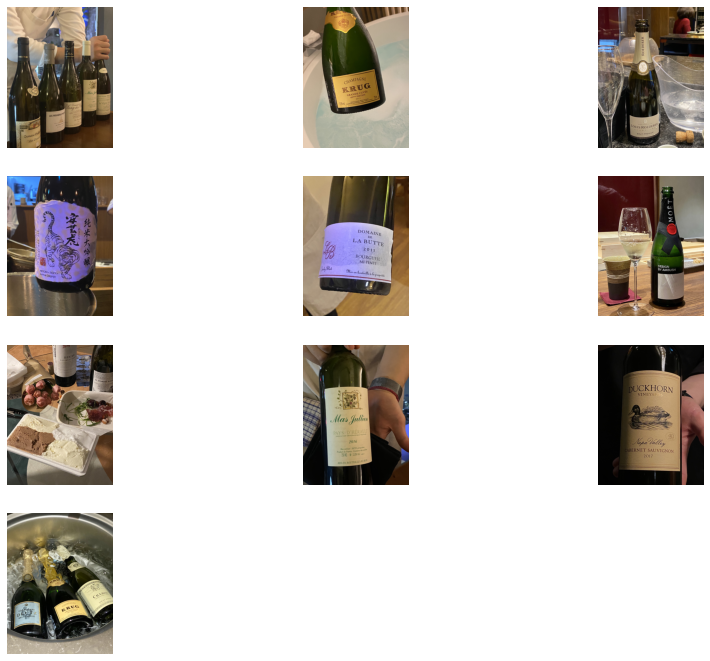

In [39]:
plt.figure(figsize=(15, 15))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 3, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

총 10개의 이미지를 가져왔다.
- 2개 사진은 각 와인 3개와 5개짜리로, 3개는 아래의 각도 5개는 옆에서 본 각도의 사진으로 가장 판별하기 어려울 사진으로 선택
- 6개 사진은 각 1개씩으로 정면에서 와인라벨만 찍은 사진 4개, 옆 각도에서 찍은 사진 2개로 가장 쉬운 테스트 사진이다.
- 한자로 된 와인 하나, 오른쪽 끄트머리에 작게 보이는 와인 라벨 하나 이것도 식별할 수 있을까?

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

#### 2-1. keras-ocr

In [40]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [41]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

IndexError: list index out of range

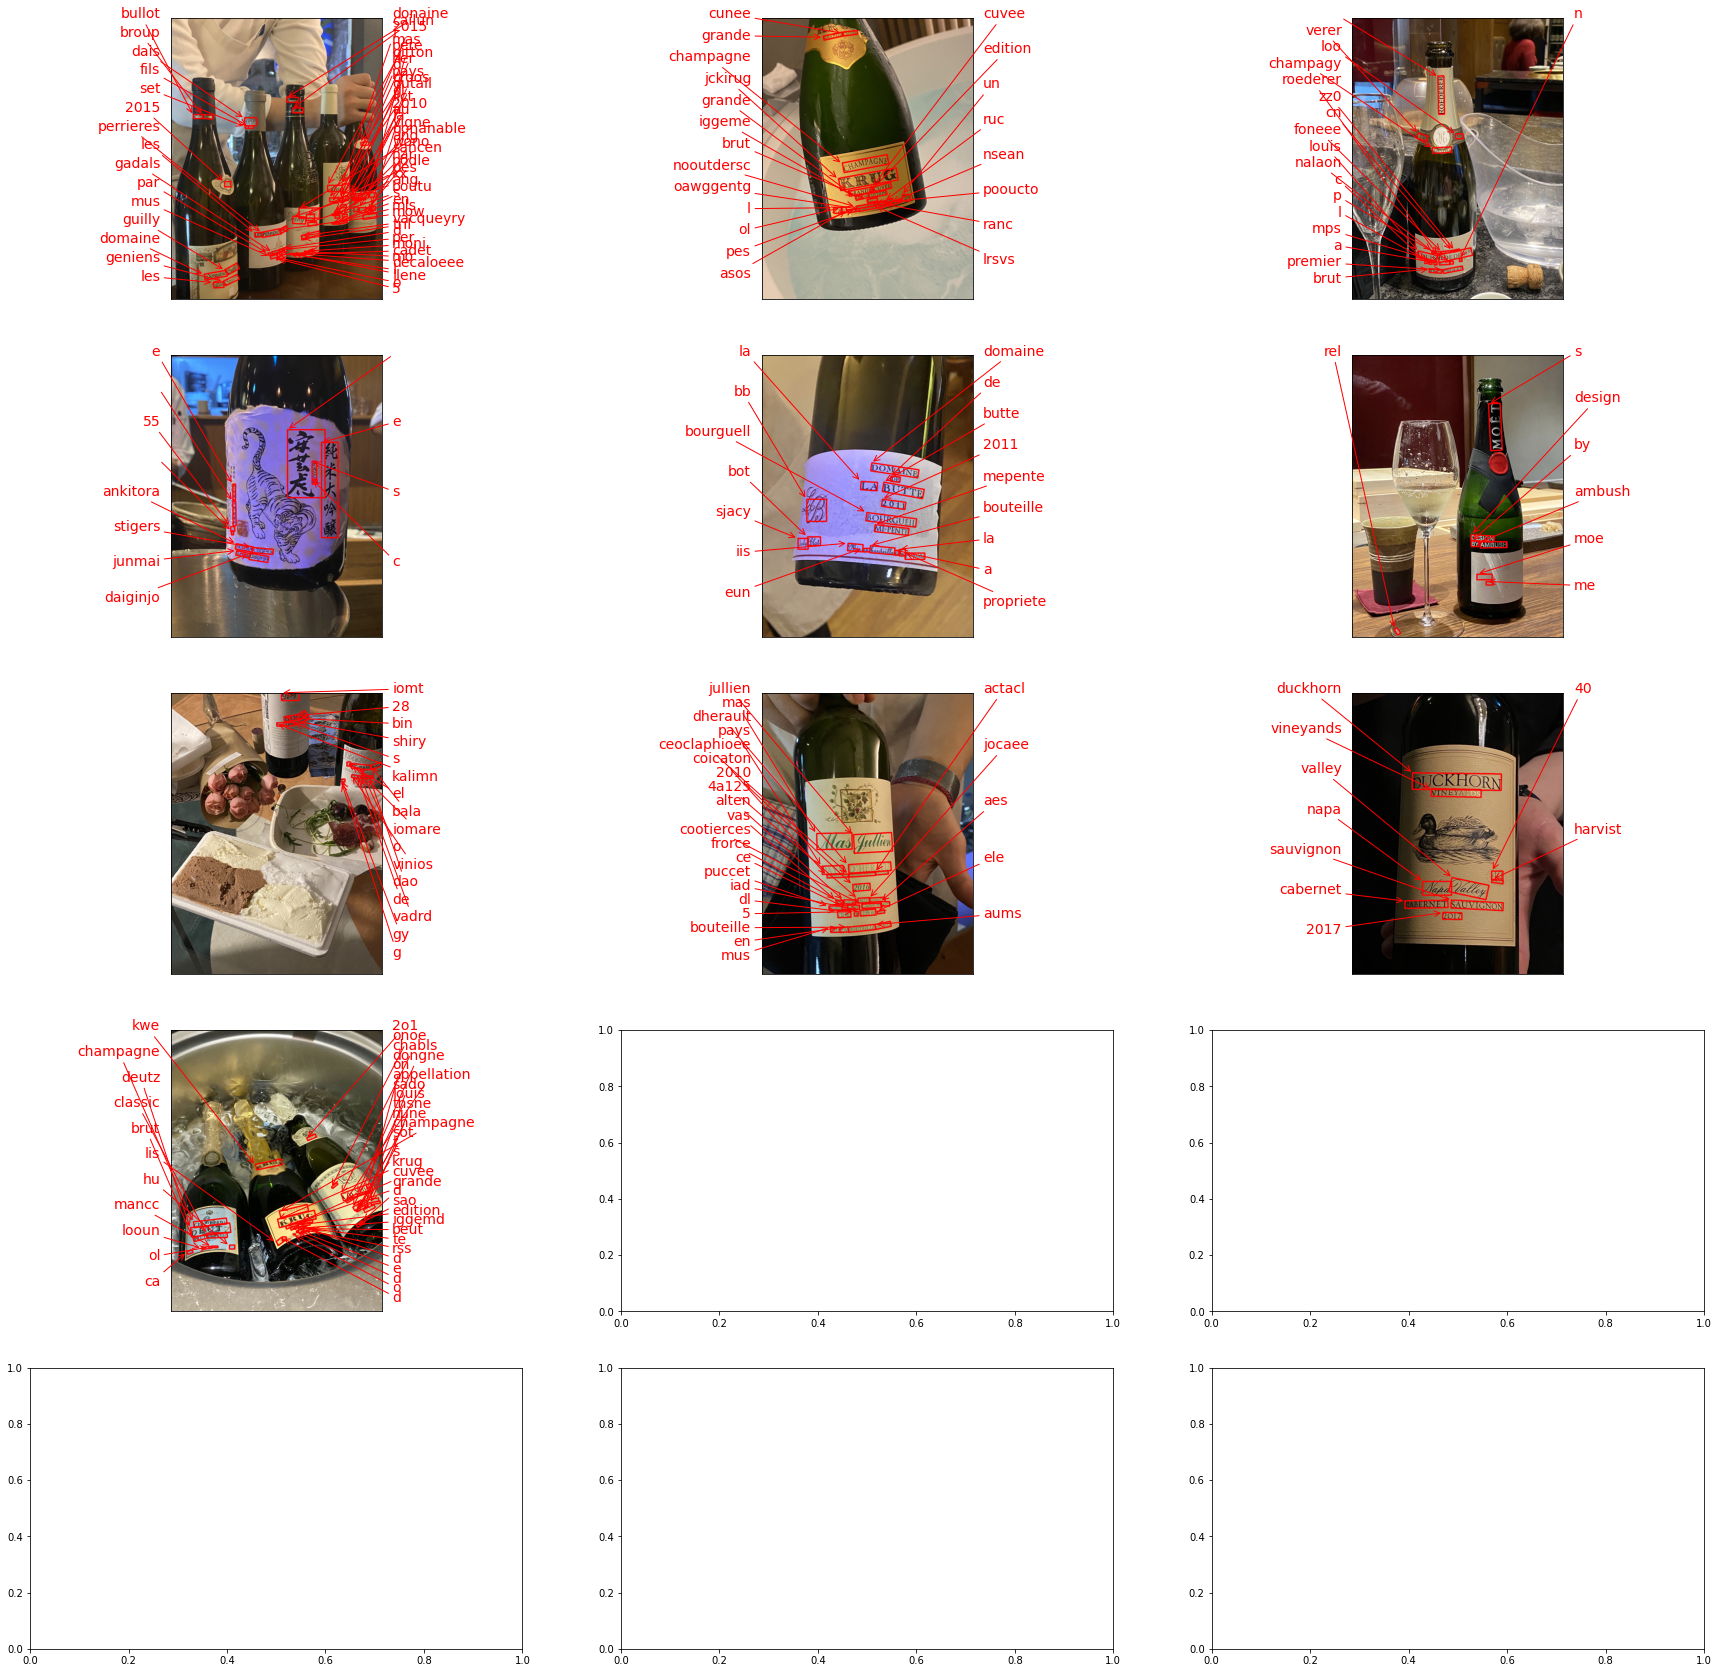

In [42]:
fig, axs = plt.subplots(5, 3, figsize=(30, 30))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[3*a+b], 
                                    predictions=predictions[3*a+b][0], ax=axs[a,b])

#### 2-2. Tesseract

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_15/wine_img'
img_file_path =  work_dir + '/KakaoTalk_20220303_180154584.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0000.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0001.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0002.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0003.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0004.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0005.png
/aiffel/aiffel/EXPLORATIONS/EX_15/wine_img/0006.png


In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

cha»

REED

Us

J

RUT

“tat > SIC


Done


- crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

- 기본적으로 pytesseract.image_to_data() 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. - 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다.

- 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 됩니다.

- IsADirectoryError: [Errno 21] Is a directory: '/'

### Step3. 테스트 결과 정리

In [62]:
# 3-1. keras-ocr

def show_keras(num):
    keras_ocr.tools.drawAnnotations(image=images[num], predictions=predictions[num][0])

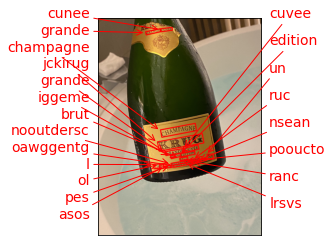

In [76]:
show_keras(1)

가장 기본 사진인 정면 사진에서 champagne, jckirug, grande, cuvee, edition, brut 등등을 보아 정확도는 떨어지지만 제대로 인식한다는 걸 알 수 있다. 하지만 역시 작은 글씨 뿐만아니라 글씨체가 특이한 경우는 인식하지 못한다(+숫자)

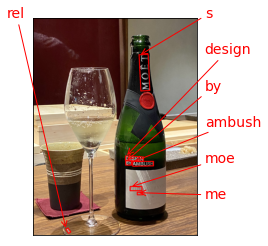

In [79]:
show_keras(5)

잔 밑에 글씨인 redel의 rel을 파악한점, design by ambush, moe등을 파악한 게 인상적이다. moe에 t는 왜 인식이 안됐을까? 잘보이는데 흠

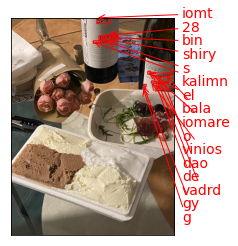

In [80]:
show_keras(6)

1번의 사진에선 숫자를 인식하지 못했는데 여기선 '28'이 인식된 게 신기하다. kalimn, el iombre, bala 등 초점이 와인이 아닌 사진임에도 인식률이 '나쁘진 않아서' 놀랐다.

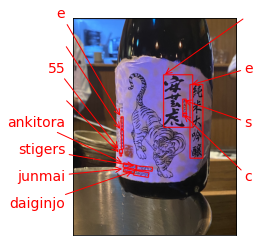

In [63]:
show_keras(3)

영어와 한문이 섞이면 인식을 하지 못한다. 아쉬웠고 더 알아보고 싶었던 부분

### Step4. 결과 분석과 결론 제시

- 구현하고자 하는 서비스의 목적과 내용을 먼저 정리. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정.

- '라벨의 모든 정보를 글로 볼 수 있는가'를 목적으로 만들었다. 와인 라벨의 모든 글을 인식할 수 있다면 리뷰, 정보 등을 첨가하여 비지니스 모델을 만들 수 있기 때문이다. 그러므로 일단 라벨의 모든 글자를 완전히 인식하는지가 중요해서 텍스트의 모양과 크기, 노이즈, 와인의 갯수, 각도를 기준으로 다양한 데이터셋을 모아 진행했다. 라벨에 있는 텍스트의 모양과 크기에 관계없이 모든 글자를 인식할 수 있는지, 다수의 와인이 있을 때 모든 라벨을 인식할 수 있는지, 각도가 정면이 아님에도 정확한 인식이 가능한지를 중점으로 판단한 결과 생각보다는 괜찮은 결과가 나왔지만 완벽하지는 않았기에 성능 높히는 방법이 궁금해졌다.

### Trial and error

- Google Cloud Vision API 사용을 못해봐서 아쉬웠다. 다른 분들 후기를 보면 이 모델이 가장 정확도가 높다는 데 궁금하다.
- 그럼에도 다른 두 모델의 결과가 생각보다 괜찮았다. 각도가 틀어져 있어도, 확인해야 할 글자가 많아도 '꽤나' 정확하게 인식했다. 물론 완벽히 정확한 건 아니고 완전히 이상한 글자를 내뱉진 않았다는 뜻이다. 
- 만약 기회가 된다면 글자 인식 뿐만이 아니라 그 글자가 의미하는 게 무엇인지 url을 띄워 이해할 수 있게 도와주는 모델을 만들어보고 싶다. 와인은 일단 '언어'와 '특정 단어'에 막혀 공부하기가 쉽지 않다. 그런 것들을 쉽게 설명해 둔 곳을 연결해서 인식한 글자를 클릭하면 설명 url을 띄어주는 형식으로 사람들이 쉽게 와인 공부할 수 있는 모델이 있다면 와인 문화를 빠르게 알릴 수 있고 또 소비촉진에 기여할 수 있을 것 같다.
- 코드를 구현하는 과정에서 아직도 애를 먹는다. 특히 다양한 errormessage에 이제는 적응할 때가 된 것 같은데 매번 새로운 메세지가 뜨고 나는 또 모르겠고 반복이다...